# 第6章：正则化技术

> **学习目标：**
> - 理解过拟合的本质和表现
> - 掌握L1/L2正则化的原理和实现
> - 学会使用Early Stopping
> - 了解数据增强和权重约束
> - 诊断和解决过拟合问题
>
> **学习时间：** 3-4小时

---

## 📚 什么是正则化？为什么需要它？

### 过拟合问题

**过拟合（Overfitting）**：模型在训练集上表现很好，但在测试集上表现差。

```
训练准确率: 99%  ✅
测试准确率: 70%  ❌  ← 过拟合！
```

### 过拟合的原因

1. **模型复杂度过高**：参数太多，表达能力太强
2. **训练数据太少**：无法覆盖所有模式
3. **训练时间太长**：模型记住了训练数据的细节
4. **噪声数据**：模型学到了噪声而非真实规律

### 正则化的作用

**正则化（Regularization）**：限制模型复杂度，提高泛化能力。

常见方法：
- **L1/L2正则化**：约束权重大小
- **Dropout**：随机失活神经元（下一章）
- **Early Stopping**：提前停止训练
- **数据增强**：增加训练样本多样性
- **Batch Normalization**：稳定训练（下一章）

---

## 📖 目录

1. **过拟合诊断**
   - 学习曲线分析
   - 欠拟合 vs 过拟合

2. **L2正则化（权重衰减）**
   - 数学原理
   - 从零实现
   - 效果对比

3. **L1正则化（稀疏性）**
   - L1 vs L2对比
   - 特征选择

4. **Early Stopping**
   - 原理和实现
   - 验证集的作用

5. **数据增强**
   - 图像数据增强
   - 其他数据增强技术

6. **综合实战**
   - MNIST数据集
   - 对比所有正则化方法

---

In [9]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


# 设置随机种子，确保结果可复现
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置随机种子
np.random.seed(42)

print("环境配置完成！")

环境配置完成！


---

## 1. 过拟合诊断

### 1.1 模拟过拟合场景

训练集大小: (70, 2)
测试集大小: (30, 2)


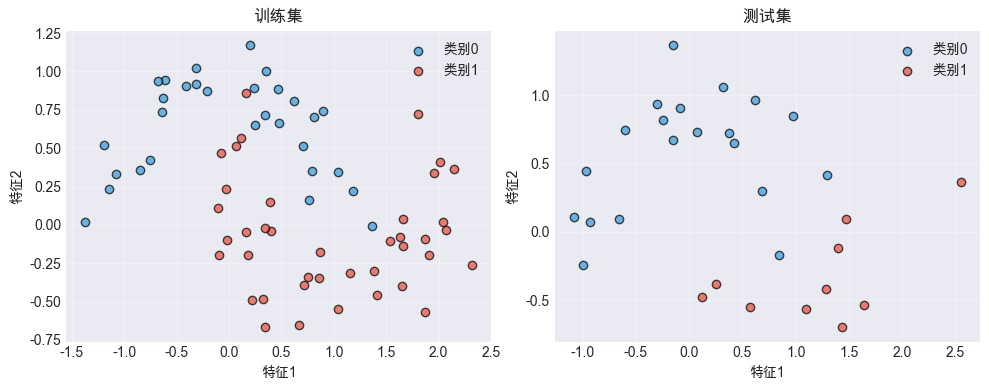

In [2]:
"""
创建一个容易过拟合的场景：
- 复杂的模型（大网络）
- 较少的训练数据
"""

# 生成月牙形数据集
X, y = make_moons(n_samples=100, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")

# 可视化数据
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
            c='#3498db', label='类别0', alpha=0.7, edgecolors='k')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
            c='#e74c3c', label='类别1', alpha=0.7, edgecolors='k')
plt.title('训练集', fontsize=12, fontweight='bold')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], 
            c='#3498db', label='类别0', alpha=0.7, edgecolors='k')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
            c='#e74c3c', label='类别1', alpha=0.7, edgecolors='k')
plt.title('测试集', fontsize=12, fontweight='bold')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.2 构建容易过拟合的模型

In [3]:
# 激活函数
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))


class OverfittingNetwork:
    """
    一个容易过拟合的深层网络
    
    结构: 2 → 64 → 64 → 32 → 1
    （参数多，容量大，容易记住训练数据）
    """
    def __init__(self):
        # 初始化权重（较大的随机值，容易过拟合）
        self.W1 = np.random.randn(64, 2) * 0.5
        self.b1 = np.zeros(64)
        
        self.W2 = np.random.randn(64, 64) * 0.5
        self.b2 = np.zeros(64)
        
        self.W3 = np.random.randn(32, 64) * 0.5
        self.b3 = np.zeros(32)
        
        self.W4 = np.random.randn(1, 32) * 0.5
        self.b4 = np.zeros(1)
    
    def forward(self, X):
        """前向传播"""
        # 第1层
        self.z1 = X @ self.W1.T + self.b1
        self.a1 = relu(self.z1)
        
        # 第2层
        self.z2 = self.a1 @ self.W2.T + self.b2
        self.a2 = relu(self.z2)
        
        # 第3层
        self.z3 = self.a2 @ self.W3.T + self.b3
        self.a3 = relu(self.z3)
        
        # 输出层
        self.z4 = self.a3 @ self.W4.T + self.b4
        self.a4 = sigmoid(self.z4)
        
        return self.a4
    
    def backward(self, X, y_true):
        """反向传播（二分类交叉熵）"""
        m = X.shape[0]
        
        # 输出层梯度
        delta4 = (self.a4 - y_true.reshape(-1, 1)) / m
        grad_W4 = delta4.T @ self.a3
        grad_b4 = np.sum(delta4, axis=0)
        
        # 第3层梯度
        delta3 = (delta4 @ self.W4) * relu_derivative(self.z3)
        grad_W3 = delta3.T @ self.a2
        grad_b3 = np.sum(delta3, axis=0)
        
        # 第2层梯度
        delta2 = (delta3 @ self.W3) * relu_derivative(self.z2)
        grad_W2 = delta2.T @ self.a1
        grad_b2 = np.sum(delta2, axis=0)
        
        # 第1层梯度
        delta1 = (delta2 @ self.W2) * relu_derivative(self.z1)
        grad_W1 = delta1.T @ X
        grad_b1 = np.sum(delta1, axis=0)
        
        return [grad_W1, grad_b1, grad_W2, grad_b2, 
                grad_W3, grad_b3, grad_W4, grad_b4]
    
    def get_params(self):
        return [self.W1, self.b1, self.W2, self.b2, 
                self.W3, self.b3, self.W4, self.b4]
    
    def set_params(self, params):
        self.W1, self.b1, self.W2, self.b2, \
        self.W3, self.b3, self.W4, self.b4 = params
    
    def compute_loss(self, X, y_true):
        """二分类交叉熵损失"""
        y_pred = self.forward(X)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def compute_accuracy(self, X, y_true):
        """计算准确率"""
        y_pred = self.forward(X)
        predictions = (y_pred >= 0.5).astype(int).flatten()
        return np.mean(predictions == y_true)


# 训练无正则化的模型
def train_without_regularization(X_train, y_train, X_test, y_test, 
                                  n_epochs=500, learning_rate=0.01):
    """
    训练无正则化的模型（观察过拟合）
    """
    model = OverfittingNetwork()
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(n_epochs):
        # 前向传播
        model.forward(X_train)
        
        # 反向传播
        grads = model.backward(X_train, y_train)
        
        # 更新参数（简单SGD）
        params = model.get_params()
        updated_params = [p - learning_rate * g for p, g in zip(params, grads)]
        model.set_params(updated_params)
        
        # 记录指标
        if epoch % 10 == 0:
            train_loss = model.compute_loss(X_train, y_train)
            test_loss = model.compute_loss(X_test, y_test)
            train_acc = model.compute_accuracy(X_train, y_train)
            test_acc = model.compute_accuracy(X_test, y_test)
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
    
    return model, train_losses, test_losses, train_accs, test_accs


# 训练模型
print("训练无正则化模型...")
model_no_reg, train_losses, test_losses, train_accs, test_accs = \
    train_without_regularization(X_train, y_train, X_test, y_test)

print(f"\n最终结果：")
print(f"训练准确率: {train_accs[-1]:.4f}")
print(f"测试准确率: {test_accs[-1]:.4f}")
print(f"\n⚠️ 训练准确率明显高于测试准确率 → 过拟合！")

训练无正则化模型...

最终结果：
训练准确率: 0.9857
测试准确率: 0.9333

⚠️ 训练准确率明显高于测试准确率 → 过拟合！


### 1.3 学习曲线分析

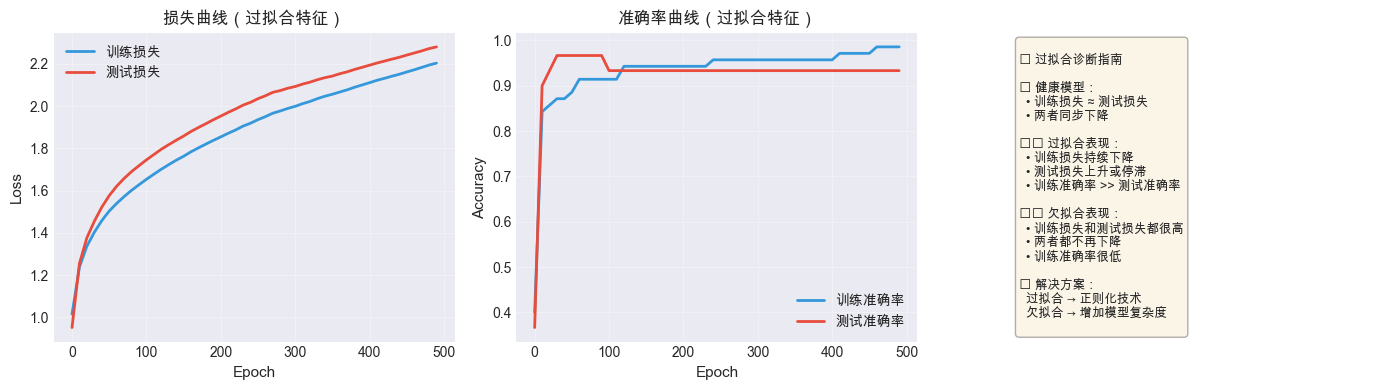

In [4]:
# 可视化学习曲线
epochs_plot = np.arange(0, len(train_losses)) * 10

plt.figure(figsize=(14, 4))

# 损失曲线
plt.subplot(1, 3, 1)
plt.plot(epochs_plot, train_losses, label='训练损失', linewidth=2, color='#3498db')
plt.plot(epochs_plot, test_losses, label='测试损失', linewidth=2, color='#e74c3c')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.title('损失曲线（过拟合特征）', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 准确率曲线
plt.subplot(1, 3, 2)
plt.plot(epochs_plot, train_accs, label='训练准确率', linewidth=2, color='#3498db')
plt.plot(epochs_plot, test_accs, label='测试准确率', linewidth=2, color='#e74c3c')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title('准确率曲线（过拟合特征）', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 过拟合诊断指南
plt.subplot(1, 3, 3)
diagnosis_text = """
🔍 过拟合诊断指南

✅ 健康模型：
  • 训练损失 ≈ 测试损失
  • 两者同步下降

⚠️ 过拟合表现：
  • 训练损失持续下降
  • 测试损失上升或停滞
  • 训练准确率 >> 测试准确率

⚠️ 欠拟合表现：
  • 训练损失和测试损失都很高
  • 两者都不再下降
  • 训练准确率很低

💡 解决方案：
  过拟合 → 正则化技术
  欠拟合 → 增加模型复杂度
"""
plt.text(0.1, 0.5, diagnosis_text, fontsize=9, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.show()

---

## 2. L2正则化（权重衰减）

### 2.1 数学原理

**标准损失函数：**
$$L(\theta) = \frac{1}{m} \sum_{i=1}^{m} \ell(f_{\theta}(x^{(i)}), y^{(i)})$$

**L2正则化损失：**
$$L_{\text{L2}}(\theta) = \frac{1}{m} \sum_{i=1}^{m} \ell(f_{\theta}(x^{(i)}), y^{(i)}) + \frac{\lambda}{2} \sum_{l} \|W^{(l)}\|_2^2$$

其中：
- $\lambda$：正则化强度（超参数）
- $\|W^{(l)}\|_2^2 = \sum_{i,j} (W^{(l)}_{i,j})^2$：权重的L2范数平方

**梯度变化：**
$$\frac{\partial L_{\text{L2}}}{\partial W^{(l)}} = \frac{\partial L}{\partial W^{(l)}} + \lambda W^{(l)}$$

**参数更新：**
$$W^{(l)} \leftarrow W^{(l)} - \alpha \left( \frac{\partial L}{\partial W^{(l)}} + \lambda W^{(l)} \right)$$
$$= (1 - \alpha \lambda) W^{(l)} - \alpha \frac{\partial L}{\partial W^{(l)}}$$

因此也叫**权重衰减（Weight Decay）**：每次更新时权重乘以 $(1 - \alpha \lambda) < 1$。

### 2.2 从零实现L2正则化

In [5]:
class NetworkWithL2:
    """
    带L2正则化的神经网络
    """
    def __init__(self, lambda_reg=0.01):
        """
        参数:
            lambda_reg: L2正则化系数 λ
        """
        self.lambda_reg = lambda_reg
        
        # 初始化权重（与OverfittingNetwork相同）
        self.W1 = np.random.randn(64, 2) * 0.5
        self.b1 = np.zeros(64)
        
        self.W2 = np.random.randn(64, 64) * 0.5
        self.b2 = np.zeros(64)
        
        self.W3 = np.random.randn(32, 64) * 0.5
        self.b3 = np.zeros(32)
        
        self.W4 = np.random.randn(1, 32) * 0.5
        self.b4 = np.zeros(1)
    
    def forward(self, X):
        """前向传播（与无正则化版本相同）"""
        self.z1 = X @ self.W1.T + self.b1
        self.a1 = relu(self.z1)
        
        self.z2 = self.a1 @ self.W2.T + self.b2
        self.a2 = relu(self.z2)
        
        self.z3 = self.a2 @ self.W3.T + self.b3
        self.a3 = relu(self.z3)
        
        self.z4 = self.a3 @ self.W4.T + self.b4
        self.a4 = sigmoid(self.z4)
        
        return self.a4
    
    def backward(self, X, y_true):
        """
        反向传播（添加L2正则化项）
        
        关键变化：
            ∂L_L2/∂W = ∂L/∂W + λ * W
        """
        m = X.shape[0]
        
        # 输出层梯度
        delta4 = (self.a4 - y_true.reshape(-1, 1)) / m
        grad_W4 = delta4.T @ self.a3 + self.lambda_reg * self.W4  # ← L2项
        grad_b4 = np.sum(delta4, axis=0)  # 偏置不正则化
        
        # 第3层梯度
        delta3 = (delta4 @ self.W4) * relu_derivative(self.z3)
        grad_W3 = delta3.T @ self.a2 + self.lambda_reg * self.W3  # ← L2项
        grad_b3 = np.sum(delta3, axis=0)
        
        # 第2层梯度
        delta2 = (delta3 @ self.W3) * relu_derivative(self.z2)
        grad_W2 = delta2.T @ self.a1 + self.lambda_reg * self.W2  # ← L2项
        grad_b2 = np.sum(delta2, axis=0)
        
        # 第1层梯度
        delta1 = (delta2 @ self.W2) * relu_derivative(self.z1)
        grad_W1 = delta1.T @ X + self.lambda_reg * self.W1  # ← L2项
        grad_b1 = np.sum(delta1, axis=0)
        
        return [grad_W1, grad_b1, grad_W2, grad_b2, 
                grad_W3, grad_b3, grad_W4, grad_b4]
    
    def get_params(self):
        return [self.W1, self.b1, self.W2, self.b2, 
                self.W3, self.b3, self.W4, self.b4]
    
    def set_params(self, params):
        self.W1, self.b1, self.W2, self.b2, \
        self.W3, self.b3, self.W4, self.b4 = params
    
    def compute_loss(self, X, y_true):
        """
        计算总损失（包含L2正则化项）
        
        L_total = L_CE + (λ/2) * Σ||W||²
        """
        y_pred = self.forward(X)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # 交叉熵损失
        ce_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # L2正则化项
        l2_penalty = 0.5 * self.lambda_reg * (
            np.sum(self.W1 ** 2) + 
            np.sum(self.W2 ** 2) + 
            np.sum(self.W3 ** 2) + 
            np.sum(self.W4 ** 2)
        )
        
        return ce_loss + l2_penalty
    
    def compute_accuracy(self, X, y_true):
        y_pred = self.forward(X)
        predictions = (y_pred >= 0.5).astype(int).flatten()
        return np.mean(predictions == y_true)


print("L2正则化网络实现完成！")
print("\n💡 关键改动：")
print("1. 梯度计算时添加 λ * W")
print("2. 损失计算时添加 (λ/2) * Σ||W||²")
print("3. 偏置项b不进行正则化")

L2正则化网络实现完成！

💡 关键改动：
1. 梯度计算时添加 λ * W
2. 损失计算时添加 (λ/2) * Σ||W||²
3. 偏置项b不进行正则化


### 2.3 对比不同λ值的效果


训练模型 (λ=0.0)...
最终测试准确率: 0.9000

训练模型 (λ=0.001)...
最终测试准确率: 0.9333

训练模型 (λ=0.01)...
最终测试准确率: 0.9667

训练模型 (λ=0.1)...
最终测试准确率: 0.9333


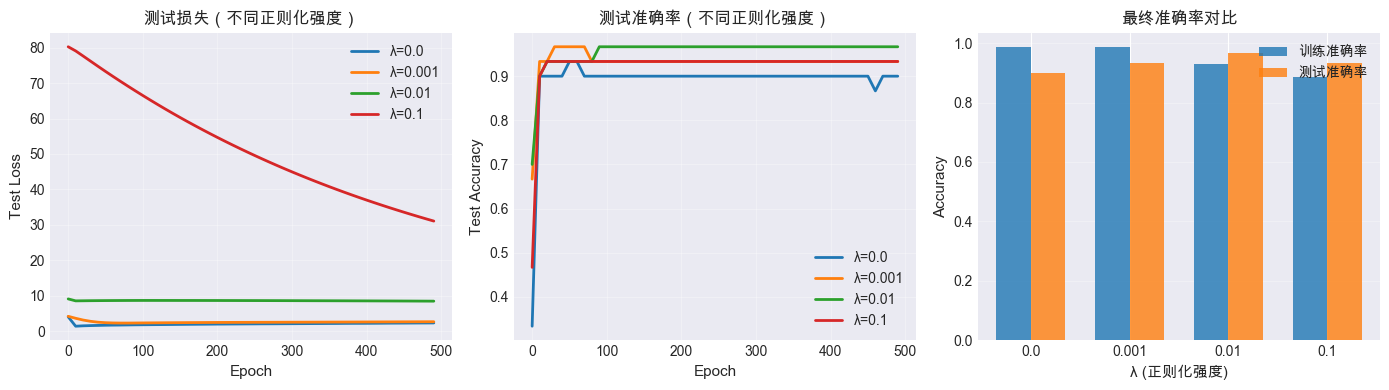


🔍 观察要点：
1. λ=0（无正则化）：过拟合严重
2. λ适中（0.001-0.01）：泛化性能提升
3. λ过大（0.1）：欠拟合，训练和测试准确率都下降


In [6]:
def train_with_l2(X_train, y_train, X_test, y_test, 
                   lambda_reg=0.01, n_epochs=500, learning_rate=0.01):
    """
    训练带L2正则化的模型
    """
    model = NetworkWithL2(lambda_reg=lambda_reg)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(n_epochs):
        model.forward(X_train)
        grads = model.backward(X_train, y_train)
        
        params = model.get_params()
        updated_params = [p - learning_rate * g for p, g in zip(params, grads)]
        model.set_params(updated_params)
        
        if epoch % 10 == 0:
            train_loss = model.compute_loss(X_train, y_train)
            test_loss = model.compute_loss(X_test, y_test)
            train_acc = model.compute_accuracy(X_train, y_train)
            test_acc = model.compute_accuracy(X_test, y_test)
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
    
    return model, train_losses, test_losses, train_accs, test_accs


# 测试不同的λ值
lambdas = [0.0, 0.001, 0.01, 0.1]
results = {}

for lam in lambdas:
    print(f"\n训练模型 (λ={lam})...")
    model, train_loss, test_loss, train_acc, test_acc = \
        train_with_l2(X_train, y_train, X_test, y_test, lambda_reg=lam)
    
    results[lam] = {
        'model': model,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_acc': train_acc,
        'test_acc': test_acc
    }
    
    print(f"最终测试准确率: {test_acc[-1]:.4f}")


# 可视化对比
epochs_plot = np.arange(0, 50) * 10

plt.figure(figsize=(14, 4))

# 测试损失对比
plt.subplot(1, 3, 1)
for lam in lambdas:
    plt.plot(epochs_plot, results[lam]['test_loss'], 
             label=f'λ={lam}', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Test Loss', fontsize=11)
plt.title('测试损失（不同正则化强度）', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 测试准确率对比
plt.subplot(1, 3, 2)
for lam in lambdas:
    plt.plot(epochs_plot, results[lam]['test_acc'], 
             label=f'λ={lam}', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Test Accuracy', fontsize=11)
plt.title('测试准确率（不同正则化强度）', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 最终结果对比
plt.subplot(1, 3, 3)
final_train_accs = [results[lam]['train_acc'][-1] for lam in lambdas]
final_test_accs = [results[lam]['test_acc'][-1] for lam in lambdas]

x_pos = np.arange(len(lambdas))
width = 0.35

plt.bar(x_pos - width/2, final_train_accs, width, label='训练准确率', alpha=0.8)
plt.bar(x_pos + width/2, final_test_accs, width, label='测试准确率', alpha=0.8)
plt.xlabel('λ (正则化强度)', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title('最终准确率对比', fontsize=12, fontweight='bold')
plt.xticks(x_pos, [f'{lam}' for lam in lambdas])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n🔍 观察要点：")
print("1. λ=0（无正则化）：过拟合严重")
print("2. λ适中（0.001-0.01）：泛化性能提升")
print("3. λ过大（0.1）：欠拟合，训练和测试准确率都下降")

---

## 3. L1正则化（稀疏性）

### 3.1 L1 vs L2对比

**L1正则化：**
$$L_{\text{L1}}(\theta) = L(\theta) + \lambda \sum_{l} \|W^{(l)}\|_1$$

其中 $\|W\|_1 = \sum_{i,j} |W_{i,j}|$

**L2正则化：**
$$L_{\text{L2}}(\theta) = L(\theta) + \frac{\lambda}{2} \sum_{l} \|W^{(l)}\|_2^2$$

其中 $\|W\|_2^2 = \sum_{i,j} W_{i,j}^2$

### 关键区别

| 特性 | L1正则化 | L2正则化 |
|-----|---------|----------|
| 惩罚项 | $\|W\|_1$ | $\|W\|_2^2$ |
| 梯度 | $\text{sign}(W)$ | $W$ |
| 效果 | **稀疏化**（很多权重变为0） | 权重均匀缩小 |
| 应用 | 特征选择 | 防止过拟合 |

### 3.2 L1正则化实现

In [7]:
"""
L1正则化的梯度：

    ∂(λ||W||_1)/∂W = λ * sign(W)

其中 sign(W) = { +1  if W > 0
               {  0  if W = 0
               { -1  if W < 0
"""

class NetworkWithL1:
    """
    带L1正则化的神经网络
    """
    def __init__(self, lambda_reg=0.01):
        self.lambda_reg = lambda_reg
        
        # 初始化权重
        self.W1 = np.random.randn(64, 2) * 0.5
        self.b1 = np.zeros(64)
        
        self.W2 = np.random.randn(64, 64) * 0.5
        self.b2 = np.zeros(64)
        
        self.W3 = np.random.randn(32, 64) * 0.5
        self.b3 = np.zeros(32)
        
        self.W4 = np.random.randn(1, 32) * 0.5
        self.b4 = np.zeros(1)
    
    def forward(self, X):
        self.z1 = X @ self.W1.T + self.b1
        self.a1 = relu(self.z1)
        
        self.z2 = self.a1 @ self.W2.T + self.b2
        self.a2 = relu(self.z2)
        
        self.z3 = self.a2 @ self.W3.T + self.b3
        self.a3 = relu(self.z3)
        
        self.z4 = self.a3 @ self.W4.T + self.b4
        self.a4 = sigmoid(self.z4)
        
        return self.a4
    
    def backward(self, X, y_true):
        """
        反向传播（添加L1正则化项）
        
        关键变化：
            ∂L_L1/∂W = ∂L/∂W + λ * sign(W)
        """
        m = X.shape[0]
        
        # 输出层梯度
        delta4 = (self.a4 - y_true.reshape(-1, 1)) / m
        grad_W4 = delta4.T @ self.a3 + self.lambda_reg * np.sign(self.W4)  # ← L1项
        grad_b4 = np.sum(delta4, axis=0)
        
        # 第3层梯度
        delta3 = (delta4 @ self.W4) * relu_derivative(self.z3)
        grad_W3 = delta3.T @ self.a2 + self.lambda_reg * np.sign(self.W3)  # ← L1项
        grad_b3 = np.sum(delta3, axis=0)
        
        # 第2层梯度
        delta2 = (delta3 @ self.W3) * relu_derivative(self.z2)
        grad_W2 = delta2.T @ self.a1 + self.lambda_reg * np.sign(self.W2)  # ← L1项
        grad_b2 = np.sum(delta2, axis=0)
        
        # 第1层梯度
        delta1 = (delta2 @ self.W2) * relu_derivative(self.z1)
        grad_W1 = delta1.T @ X + self.lambda_reg * np.sign(self.W1)  # ← L1项
        grad_b1 = np.sum(delta1, axis=0)
        
        return [grad_W1, grad_b1, grad_W2, grad_b2, 
                grad_W3, grad_b3, grad_W4, grad_b4]
    
    def get_params(self):
        return [self.W1, self.b1, self.W2, self.b2, 
                self.W3, self.b3, self.W4, self.b4]
    
    def set_params(self, params):
        self.W1, self.b1, self.W2, self.b2, \
        self.W3, self.b3, self.W4, self.b4 = params
    
    def compute_loss(self, X, y_true):
        y_pred = self.forward(X)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        ce_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # L1正则化项
        l1_penalty = self.lambda_reg * (
            np.sum(np.abs(self.W1)) + 
            np.sum(np.abs(self.W2)) + 
            np.sum(np.abs(self.W3)) + 
            np.sum(np.abs(self.W4))
        )
        
        return ce_loss + l1_penalty
    
    def compute_accuracy(self, X, y_true):
        y_pred = self.forward(X)
        predictions = (y_pred >= 0.5).astype(int).flatten()
        return np.mean(predictions == y_true)
    
    def count_zero_weights(self):
        """统计接近0的权重数量（稀疏性指标）"""
        threshold = 1e-3
        total_params = (
            self.W1.size + self.W2.size + 
            self.W3.size + self.W4.size
        )
        zero_params = (
            np.sum(np.abs(self.W1) < threshold) + 
            np.sum(np.abs(self.W2) < threshold) + 
            np.sum(np.abs(self.W3) < threshold) + 
            np.sum(np.abs(self.W4) < threshold)
        )
        return zero_params, total_params


print("L1正则化网络实现完成！")
print("\n💡 关键特点：")
print("1. 梯度使用 sign(W) 而非 W")
print("2. 会产生稀疏权重（很多权重变为0）")
print("3. 可用于特征选择")

L1正则化网络实现完成！

💡 关键特点：
1. 梯度使用 sign(W) 而非 W
2. 会产生稀疏权重（很多权重变为0）
3. 可用于特征选择


### 3.3 L1 vs L2效果对比

训练L1模型...
训练L2模型...


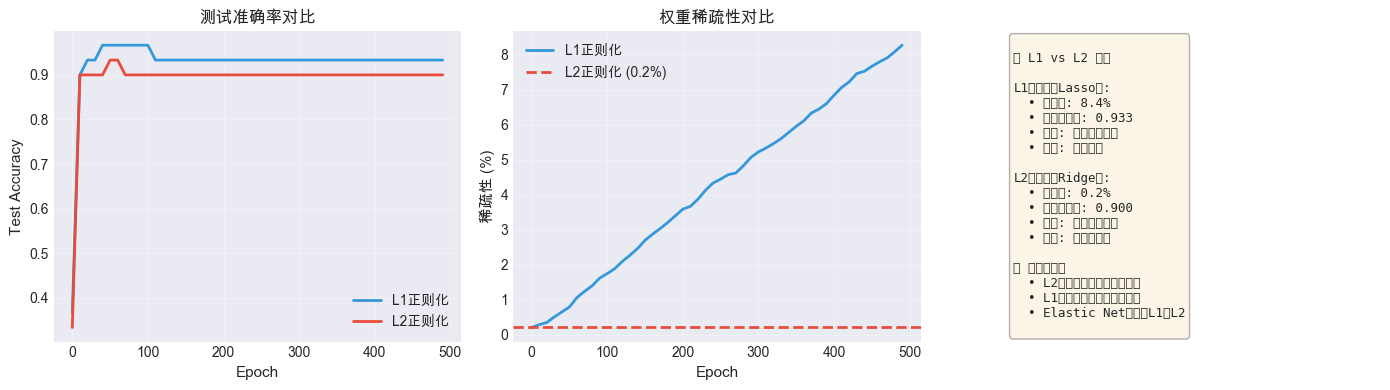


📊 最终结果：
L1正则化 - 稀疏性: 8.4%, 测试准确率: 0.9333
L2正则化 - 稀疏性: 0.2%, 测试准确率: 0.9000


In [10]:
def train_with_l1(X_train, y_train, X_test, y_test, 
                   lambda_reg=0.01, n_epochs=500, learning_rate=0.01):
    """训练带L1正则化的模型"""
    model = NetworkWithL1(lambda_reg=lambda_reg)
    
    train_accs = []
    test_accs = []
    sparsity = []  # 稀疏性记录
    
    for epoch in range(n_epochs):
        model.forward(X_train)
        grads = model.backward(X_train, y_train)
        
        params = model.get_params()
        updated_params = [p - learning_rate * g for p, g in zip(params, grads)]
        model.set_params(updated_params)
        
        if epoch % 10 == 0:
            train_acc = model.compute_accuracy(X_train, y_train)
            test_acc = model.compute_accuracy(X_test, y_test)
            zero_w, total_w = model.count_zero_weights()
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            sparsity.append(zero_w / total_w * 100)
    
    return model, train_accs, test_accs, sparsity


# 训练L1和L2模型
print("训练L1模型...")
model_l1, train_accs_l1, test_accs_l1, sparsity_l1 = \
    train_with_l1(X_train, y_train, X_test, y_test, lambda_reg=0.01)

print("训练L2模型...")
model_l2, _, _, train_accs_l2, test_accs_l2 = \
    train_with_l2(X_train, y_train, X_test, y_test, lambda_reg=0.01)

# 计算L2模型的稀疏性
threshold = 1e-3
total_l2 = model_l2.W1.size + model_l2.W2.size + model_l2.W3.size + model_l2.W4.size
zero_l2 = (np.sum(np.abs(model_l2.W1) < threshold) + 
           np.sum(np.abs(model_l2.W2) < threshold) + 
           np.sum(np.abs(model_l2.W3) < threshold) + 
           np.sum(np.abs(model_l2.W4) < threshold))
sparsity_l2_final = zero_l2 / total_l2 * 100

zero_l1, total_l1 = model_l1.count_zero_weights()
sparsity_l1_final = zero_l1 / total_l1 * 100


# 可视化对比
epochs_plot = np.arange(0, 50) * 10

plt.figure(figsize=(14, 4))

# 测试准确率对比
plt.subplot(1, 3, 1)
plt.plot(epochs_plot, test_accs_l1, label='L1正则化', linewidth=2, color='#3498db')
plt.plot(epochs_plot, test_accs_l2, label='L2正则化', linewidth=2, color='#e74c3c')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Test Accuracy', fontsize=11)
plt.title('测试准确率对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 稀疏性对比
plt.subplot(1, 3, 2)
plt.plot(epochs_plot, sparsity_l1, label='L1正则化', linewidth=2, color='#3498db')
plt.axhline(y=sparsity_l2_final, color='#e74c3c', linestyle='--', 
            linewidth=2, label=f'L2正则化 ({sparsity_l2_final:.1f}%)')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('稀疏性 (%)', fontsize=11)
plt.title('权重稀疏性对比', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# L1 vs L2总结
plt.subplot(1, 3, 3)
comparison_text = f"""
🔍 L1 vs L2 对比

L1正则化（Lasso）:
  • 稀疏性: {sparsity_l1_final:.1f}%
  • 测试准确率: {test_accs_l1[-1]:.3f}
  • 效果: 产生稀疏权重
  • 应用: 特征选择

L2正则化（Ridge）:
  • 稀疏性: {sparsity_l2_final:.1f}%
  • 测试准确率: {test_accs_l2[-1]:.3f}
  • 效果: 权重均匀缩小
  • 应用: 防止过拟合

💡 选择建议：
  • L2：大多数场景的默认选择
  • L1：需要特征选择或解释性
  • Elastic Net：结合L1和L2
"""
plt.text(0.1, 0.5, comparison_text, fontsize=9, verticalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n📊 最终结果：")
print(f"L1正则化 - 稀疏性: {sparsity_l1_final:.1f}%, 测试准确率: {test_accs_l1[-1]:.4f}")
print(f"L2正则化 - 稀疏性: {sparsity_l2_final:.1f}%, 测试准确率: {test_accs_l2[-1]:.4f}")

---

## 4. Early Stopping（提前停止）

### 4.1 原理

**Early Stopping思想：**
- 在验证集上监控模型性能
- 当验证性能不再提升时，停止训练
- 防止过拟合

**算法流程：**
```
1. 将数据分为：训练集、验证集、测试集
2. 每个epoch后，在验证集上评估性能
3. 记录验证性能最好的模型
4. 如果验证性能连续N个epoch不提升，停止训练
5. 返回验证性能最好的模型
```

### 4.2 实现Early Stopping

训练集: (64, 2), 验证集: (16, 2), 测试集: (20, 2)

使用Early Stopping训练...
Early Stopping at epoch 21
Best validation accuracy: 0.8750


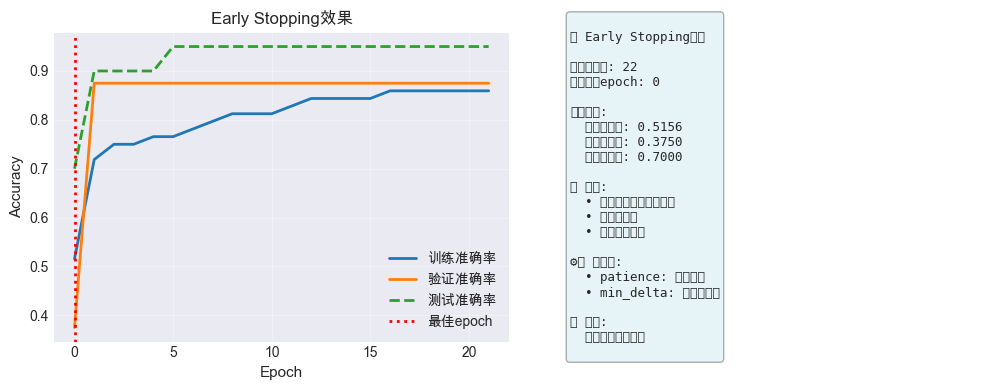

In [11]:
class EarlyStopping:
    """
    Early Stopping工具类
    
    参数:
        patience: 容忍验证性能不提升的轮数
        min_delta: 最小改进量（小于此值视为无改进）
    """
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        
        self.best_score = None
        self.best_epoch = 0
        self.counter = 0
        self.best_params = None
        self.early_stop = False
    
    def __call__(self, val_score, model):
        """
        检查是否应该停止训练
        
        参数:
            val_score: 当前验证集上的性能（越大越好，如准确率）
            model: 当前模型
        
        返回:
            should_stop: 是否应该停止训练
        """
        # 第一次调用
        if self.best_score is None:
            self.best_score = val_score
            self.best_params = [p.copy() for p in model.get_params()]
            return False
        
        # 检查是否有改进
        if val_score > self.best_score + self.min_delta:
            # 有改进
            self.best_score = val_score
            self.best_epoch = self.counter
            self.best_params = [p.copy() for p in model.get_params()]
            self.counter = 0
        else:
            # 无改进
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        
        return False


def train_with_early_stopping(X_train, y_train, X_val, y_val, X_test, y_test,
                                patience=20, n_epochs=500, learning_rate=0.01):
    """
    使用Early Stopping训练模型
    """
    model = OverfittingNetwork()
    early_stopping = EarlyStopping(patience=patience)
    
    train_accs = []
    val_accs = []
    test_accs = []
    
    for epoch in range(n_epochs):
        # 训练
        model.forward(X_train)
        grads = model.backward(X_train, y_train)
        
        params = model.get_params()
        updated_params = [p - learning_rate * g for p, g in zip(params, grads)]
        model.set_params(updated_params)
        
        # 评估
        train_acc = model.compute_accuracy(X_train, y_train)
        val_acc = model.compute_accuracy(X_val, y_val)
        test_acc = model.compute_accuracy(X_test, y_test)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        
        # 检查Early Stopping
        if early_stopping(val_acc, model):
            print(f"Early Stopping at epoch {epoch}")
            print(f"Best validation accuracy: {early_stopping.best_score:.4f}")
            break
    
    # 恢复最佳模型
    model.set_params(early_stopping.best_params)
    
    return model, train_accs, val_accs, test_accs, early_stopping.best_epoch


# 划分训练集、验证集、测试集
X_temp, X_test_es, y_temp, y_test_es = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print(f"训练集: {X_train_es.shape}, 验证集: {X_val_es.shape}, 测试集: {X_test_es.shape}")

# 训练
print("\n使用Early Stopping训练...")
model_es, train_accs_es, val_accs_es, test_accs_es, best_epoch = \
    train_with_early_stopping(X_train_es, y_train_es, X_val_es, y_val_es, 
                               X_test_es, y_test_es, patience=20)

# 可视化
epochs_es = np.arange(len(train_accs_es))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_es, train_accs_es, label='训练准确率', linewidth=2)
plt.plot(epochs_es, val_accs_es, label='验证准确率', linewidth=2)
plt.plot(epochs_es, test_accs_es, label='测试准确率', linewidth=2, linestyle='--')
plt.axvline(x=best_epoch, color='red', linestyle=':', linewidth=2, label='最佳epoch')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title('Early Stopping效果', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
info_text = f"""
📊 Early Stopping结果

总训练轮数: {len(train_accs_es)}
最佳验证epoch: {best_epoch}

最终性能:
  训练准确率: {train_accs_es[best_epoch]:.4f}
  验证准确率: {val_accs_es[best_epoch]:.4f}
  测试准确率: {test_accs_es[best_epoch]:.4f}

💡 优点:
  • 自动选择最佳训练轮数
  • 防止过拟合
  • 节省训练时间

⚙️ 超参数:
  • patience: 容忍轮数
  • min_delta: 最小改进量

📌 注意:
  需要额外的验证集
"""
plt.text(0.1, 0.5, info_text, fontsize=9, verticalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.show()

---

## 5. 本章总结

### 正则化方法对比

| 方法 | 原理 | 优点 | 缺点 | 适用场景 |
|-----|------|------|------|----------|
| **L2正则化** | 惩罚权重平方和 | 稳定、常用 | 不产生稀疏性 | 大多数场景 |
| **L1正则化** | 惩罚权重绝对值和 | 产生稀疏性 | 梯度不连续 | 特征选择 |
| **Early Stopping** | 监控验证集性能 | 简单有效 | 需要验证集 | 所有场景 |
| **Dropout** | 随机失活神经元 | 强正则化 | 训练时间长 | 深度网络（下一章） |
| **Data Augmentation** | 增加数据多样性 | 提升泛化 | 依赖任务 | 图像、文本 |

---

### 实践建议

1. **优先尝试L2正则化 + Early Stopping**
   ```python
   model = NetworkWithL2(lambda_reg=0.01)
   early_stopping = EarlyStopping(patience=20)
   ```

2. **调整正则化强度λ**
   - 从0.001开始尝试
   - 根据验证集性能调整
   - λ过大会导致欠拟合

3. **结合多种正则化方法**
   - L2 + Early Stopping
   - L2 + Dropout（下一章）
   - Data Augmentation + 所有方法

---

### 诊断过拟合的步骤

```
1. 绘制学习曲线（训练 vs 验证）
2. 观察gap：
   - gap小 → 健康
   - gap大 → 过拟合
   - 都高 → 欠拟合
3. 根据诊断结果选择策略：
   - 过拟合 → 增加正则化
   - 欠拟合 → 增加模型复杂度
```

---

## 6. 练习题

### 练习1：实现Elastic Net正则化
Elastic Net结合了L1和L2：
$$L = L_{\text{CE}} + \alpha \lambda \|W\|_1 + \frac{1-\alpha}{2} \lambda \|W\|_2^2$$

其中 $\alpha \in [0, 1]$ 控制L1和L2的比例。

### 练习2：数据增强实验
在MNIST数据集上实现简单的数据增强：
- 随机旋转（±15度）
- 随机平移
- 添加噪声

观察对泛化性能的影响。

### 练习3：最佳λ搜索
使用验证集，搜索L2正则化的最佳λ值：
- 候选值：[0.0001, 0.001, 0.01, 0.1, 1.0]
- 绘制验证性能 vs λ的曲线
- 找到最佳λ

### 练习4：过拟合可视化
在2D分类任务上：
1. 训练一个过拟合的模型
2. 绘制决策边界
3. 对比无正则化 vs L2正则化的决策边界差异

---

## 下一章预告

在下一章《批归一化与Dropout》中，我们将学习：
- Batch Normalization原理和实现
- Dropout的工作机制
- 训练时和推理时的差异
- 现代正则化技术

---

**🎓 恭喜完成第6章！你已经掌握了防止过拟合的核心技术！**